In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/tweeteval-a-multi-task-classification-benchmark")

print("Path to dataset files:", path)

In [ ]:
# DATASET LINK
# https://www.kaggle.com/datasets/thedevastator/tweeteval-a-multi-task-classification-benchmark/data

# emoji_train.csv
# emoji_test.csv
# emoji_validation.csv

In [ ]:
# the pretrained embedding for word vectorisation is taken from stanford GloVe 
# https://nlp.stanford.edu/projects/glove/

In [ ]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("emoji_train.csv")
df.head()

In [ ]:
df.info()

In [ ]:
sb.histplot(df["label"],bins=20)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Suppose you already have your texts
texts = ["example sentence one", "another example sentence"]

# Tokenize and pad sequences to length 32
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
max_length = 32

sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# Load GloVe embeddings (100-dimensional)
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
embedding_index = {}
with open("glove.twitter.27B.25d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
lst = list(embedding_index.keys())
print( lst[0:10] ) 
print(embedding_index["user"]) 
# so embedded vector size is 25

In [78]:
maxLen = 0
vocab = {}
index = 1
for s in df["text"]:
  # print(s.lower())
  words = re.findall(r"\b\w+\b",s.lower())
  maxLen = max(maxLen,len(words))
  for word in words:
    if(vocab.get(word)==None):
      vocab[word]=index
      index+=1
vocabSize = len(vocab)
print(vocabSize)
print(maxLen)

54067
32


In [ ]:
embedding_dim = 25 # bcs embedded vector size of 25d is 25
embedding_matrix = np.zeros((vocabSize+1, embedding_dim)) 
progress = 0 
for word, i in vocab.items(): 
    if(progress % 200 == 0 ) : print(progress) 
    progress+=1
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [52]:
print(embedding_matrix[7500])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [80]:
wordVectors = []
for i in range(len(df)):
  wordVec = np.zeros(maxLen)
  words = re.findall(r"\b\w+\b",df.loc[i]["text"].lower())
  for j in range(min(len(words),maxLen)):
    if(vocab.get(words[j])) : wordVec[j]=vocab[words[j]]
  wordVectors.append(wordVec)
# print(wordVectors[0:10])

In [81]:
X_train = np.array(wordVectors)
Y_train = df["label"].values

In [82]:
df_val = pd.read_csv("emoji_validation.csv")
df_val.info()
X_val_temp = df_val.drop("label",axis=1).values
X_val = []
for x in X_val_temp:
  wordVec = np.zeros(maxLen)
  words = re.findall(r"\b\w+\b",x[0].lower())
  for j in range(min(len(words),maxLen)):
    if(vocab.get(words[j])) : wordVec[j]=vocab[words[j]]
  X_val.append(wordVec)
X_val = np.array(X_val)
Y_val = df_val["label"].values
# print(X_val[0:2])
# print(Y_val[0:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [83]:
df_test = pd.read_csv("emoji_test.csv")
df_test.info()
X_test_temp = df_test.drop("label",axis=1).values
X_test = []
for x in X_test_temp:
  wordVec = np.zeros(maxLen)
  words = re.findall(r"\b\w+\b",x[0].lower())
  for j in range(min(len(words),maxLen)):
    if(vocab.get(words[j])) : wordVec[j]=vocab[words[j]]
  X_test.append(wordVec)
X_test = np.array(X_test)
Y_test = df_test["label"].values
# print(X_val[0:2])
# print(Y_val[0:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [98]:
num_classes = 20
print(vocabSize,embedding_dim,maxLen)

model = Sequential()
model.add(Embedding(
    input_dim=vocabSize+1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_shape=(maxLen,),
    trainable=False  # freeze pretrained embeddings
))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2 ,return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

54067 25 32


C:\Users\anagh\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 32, 25)         │     1,351,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,376,040 (5.25 MB)

 Trainable params: 24,340 (95.08 KB)

 Non-trainable params: 1,351,700 (5.16 MB)

In [100]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=64
)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.2603 - loss: 2.5073 - val_accuracy: 0.2688 - val_loss: 2.4807
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.2654 - loss: 2.4913 - val_accuracy: 0.2724 - val_loss: 2.4649
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.2665 - loss: 2.4770 - val_accuracy: 0.2764 - val_loss: 2.4584
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.2684 - loss: 2.4642 - val_accuracy: 0.2758 - val_loss: 2.4506
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.2733 - loss: 2.4556 - val_accuracy: 0.2772 - val_loss: 2.4362
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.2748 - loss: 2.4483 - val_accuracy: 0.2758 - val_loss: 2.4295
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.2772 - loss: 2.4415 - val_accuracy: 0.2766 - val_loss: 2.4270
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.2780 - loss: 2.4325 - 

In [59]:
num_classes = len(np.unique(Y_train)) # Determine the number of unique classes

model = Sequential([
    Embedding(input_dim=vocabSize + 1, output_dim=64, input_shape=(maxLen,)), # Adjusted input_dim
    LSTM(units=64,dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation="softmax") # Changed for multi-class classification
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) # Changed loss function
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.summary()

C:\Users\anagh\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 32, 64)         │     3,460,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,494,676 (13.33 MB)

 Trainable params: 3,494,676 (13.33 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=64
    # callbacks=[early_stop]
)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.2039 - loss: 2.7470 - val_accuracy: 0.2110 - val_loss: 2.7314
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.2216 - loss: 2.6228 - val_accuracy: 0.2396 - val_loss: 2.5932
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.2694 - loss: 2.4684 - val_accuracy: 0.2556 - val_loss: 2.5818
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.3146 - loss: 2.2905 - val_accuracy: 0.2588 - val_loss: 2.6155
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.3679 - loss: 2.0868 - val_accuracy: 0.2466 - val_loss: 2.6874
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4336 - loss: 1.8693 - val_accuracy: 0.2324 - val_loss: 2.7387
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4929 - loss: 1.6597 - val_accuracy: 0.2472 - val_loss: 2.8301
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.5506 - loss: 1.4653 - 

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [101]:
Y_predicted = model.predict(X_test) 

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step


In [102]:
Y_pred = [] 
for y in Y_predicted: 
    maxIndex = 0 
    for i in range(len(y)): 
        if(y[i]>y[maxIndex]) : maxIndex = i  
    Y_pred.append(maxIndex)

accuracy = accuracy_score(Y_test,Y_pred) 
precision = precision_score(Y_test,Y_pred, average="macro") 
recall = recall_score(Y_test,Y_pred, average="macro") 
f1 = f1_score(Y_test,Y_pred, average="macro")  

print(accuracy)
print(precision)
print(recall)
print(f1)

0.29574
0.20916231320629763
0.15025154089973958
0.1359252502127996


C:\Users\anagh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
model.save("LSTM_64_29acc.keras")

In [104]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

<Axes: ylabel='Count'>

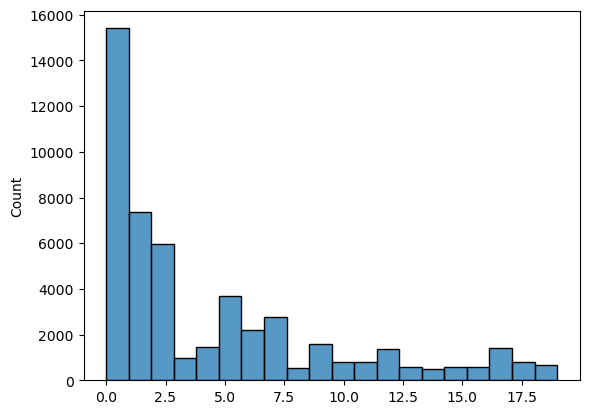

In [75]:
sb.histplot(Y_pred,bins=20)

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
num_classes = len(np.unique(Y_train)) # Determine the number of unique classes

model = Sequential([
    Embedding(input_dim=vocabSize + 1, output_dim=100, input_shape=(maxLen,)),
    Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)),
    Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(num_classes, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

In [105]:
!pip install customtkinter


   -------------------- ------------------- 1/2 [customtkinter]
   -------------------- ------------------- 1/2 [customtkinter]
   -------------------- ------------------- 1/2 [customtkinter]
   -------------------- ------------------- 1/2 [customtkinter]
   -------------------- ------------------- 1/2 [customtkinter]
   ---------------------------------------- 2/2 [customtkinter]

